# ---------------------------- Libraries -------------------

In [1]:
import numpy as np
import os
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# ------------------ Load Features ------------------

In [2]:
FEATURES_FOLDER = "enhanced_features"  # Local path where X.npy and y.npy are stored
X = np.load(os.path.join(FEATURES_FOLDER, "X.npy"))
y = np.load(os.path.join(FEATURES_FOLDER, "y.npy"))
print("Features Loaded:", X.shape, y.shape)

# Split dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model & reports directory
MODEL_DIR = "saved_models"
PLOTS_DIR = os.path.join(MODEL_DIR, "plots")
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

# Detect GPU for PyTorch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using Device: {device.upper()}")

Features Loaded: (4071, 24341) (4071,)
Using Device: CPU


# ------------------ Load Models ------------------

In [3]:
def load_model(model_name, is_xgb=False, is_torch=False):
    model_path = os.path.join(MODEL_DIR, f"{model_name}.pkl" if not is_torch else f"{model_name}.pth")

    if not os.path.exists(model_path):
        raise FileNotFoundError(f"{model_name} model not found at {model_path}. Ensure it's downloaded from Colab.")

    print(f"Loading {model_name} model...")

    if is_xgb:
        try:
            # Try loading as .pkl first
            model = joblib.load(model_path)
        except Exception as e:
            print(f"Failed to load {model_name} as .pkl. Trying .json format...")
            # If .pkl fails, try loading as XGBoost native format
            model = xgb.XGBClassifier()
            model.load_model(model_path.replace(".pkl", ".json"))  # Adjusted to try .json
    elif is_torch:
        model = MLP(X_train.shape[1]).to(device)
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()
    else:
        model = joblib.load(model_path)

    print(f"{model_name} model loaded successfully.")
    return model

In [4]:
svm_model = load_model("SVM")
rf_model = load_model("RandomForest")
xgb_model = load_model("XGBoost", is_xgb=True)

class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 384)
        self.fc2 = nn.Linear(384, 192)
        self.fc3 = nn.Linear(192, 96)
        self.fc4 = nn.Linear(96, 48)
        self.fc5 = nn.Linear(48, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        return self.fc5(x)
mlp_model = load_model("MLP", is_torch=True)

Loading SVM model...
SVM model loaded successfully.
Loading RandomForest model...
RandomForest model loaded successfully.
Loading XGBoost model...
XGBoost model loaded successfully.
Loading MLP model...
MLP model loaded successfully.


# ------------------ Evaluate Models ------------------

In [5]:
def evaluate_model(model, model_name, is_torch=False):
    print(f"\nEvaluating {model_name}...")

    if is_torch:
        with torch.no_grad():
            X_test_torch = torch.tensor(X_test, dtype=torch.float32).to(device)
            outputs = model(X_test_torch)
            y_pred = torch.argmax(outputs, dim=1).cpu().numpy()
    else:
        y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {acc:.4f}")

    # Print classification report
    report_path = os.path.join(MODEL_DIR, f"{model_name}_report.txt")
    if os.path.exists(report_path):
        with open(report_path, "r") as f:
            print(f.read())
    else:
        print(classification_report(y_test, y_pred))

    # Display confusion matrix
    cm_path = os.path.join(PLOTS_DIR, f"{model_name}_confusion_matrix.png")
    if os.path.exists(cm_path):
        img = plt.imread(cm_path)
        plt.figure(figsize=(6, 4))
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"{model_name} Confusion Matrix")
        plt.show()
    else:
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title(f"{model_name} Confusion Matrix")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.show()

    return acc

# ------------------ Evaluate All Models ------------------


Evaluating SVM...
SVM Accuracy: 0.9387
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       446
           1       0.91      0.95      0.93       369

    accuracy                           0.94       815
   macro avg       0.94      0.94      0.94       815
weighted avg       0.94      0.94      0.94       815



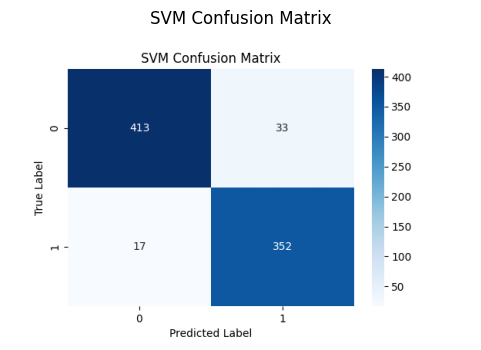


Evaluating MLP...
MLP Accuracy: 0.9325
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       446
           1       0.92      0.93      0.93       369

    accuracy                           0.93       815
   macro avg       0.93      0.93      0.93       815
weighted avg       0.93      0.93      0.93       815



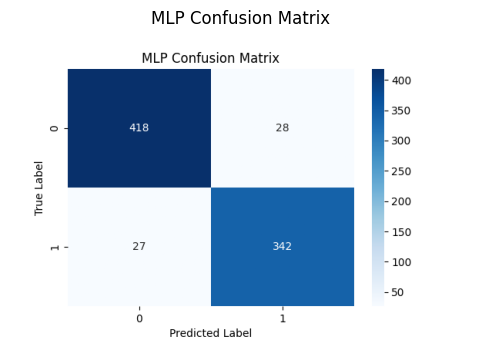


Evaluating XGBoost...


c:\Users\offic\OneDrive\Desktop\Work Env\Semester-6\VR\Projects\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [23:46:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.9264
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       446
           1       0.92      0.92      0.92       369

    accuracy                           0.93       815
   macro avg       0.93      0.93      0.93       815
weighted avg       0.93      0.93      0.93       815



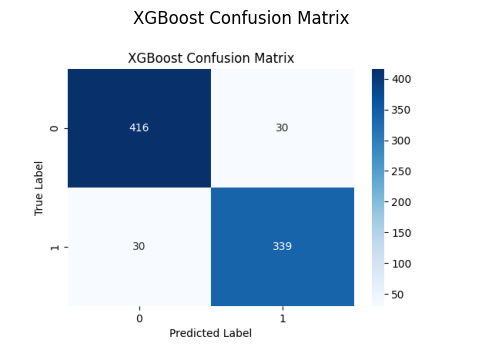


Evaluating RandomForest...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


RandomForest Accuracy: 0.9006
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       446
           1       0.91      0.87      0.89       369

    accuracy                           0.90       815
   macro avg       0.90      0.90      0.90       815
weighted avg       0.90      0.90      0.90       815



[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.2s finished


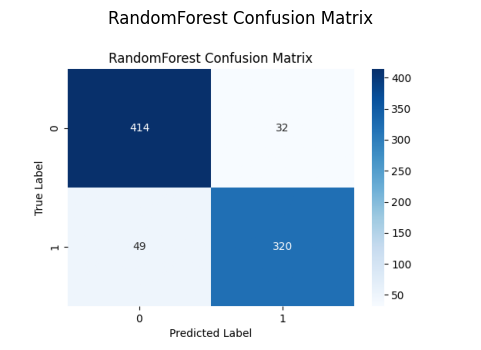


Model Comparison:
SVM: 0.9387
MLP: 0.9325
XGBoost: 0.9264
RandomForest: 0.9006

Saved Models in 'saved_models' Directory:
accuracy_log.txt
MLP.pth
MLP_report.txt
plots
RandomForest.pkl
RandomForest_report.txt
SVM.pkl
SVM_report.txt
XGBoost.pkl
XGBoost_report.txt


In [6]:
models = {
    "SVM": svm_model,
    "MLP": mlp_model,
    "XGBoost": xgb_model,
    "RandomForest": rf_model
}

accuracies = {name: evaluate_model(model, name, is_torch=(name == "MLP")) for name, model in models.items()}

# Print Comparison of Accuracies
print("\nModel Comparison:")
for name, acc in accuracies.items():
    print(f"{name}: {acc:.4f}")

# List saved models
print("\nSaved Models in 'saved_models' Directory:")
for file in os.listdir(MODEL_DIR):
    print(file)